# Make and model popularity in time

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 20

register_data_path = '../../../vehicle_register/data/'


## Load data

In [2]:
register_cols = [
    'FirstRegistrationCZ',
    'Make',
    'Model',
]

register_dtypes = {
    'FirstRegistrationCZ': 'category',
    'Make': 'category',
    'Model': 'category',
}

df_register = pd.read_csv(
    f'{register_data_path}nosync/registr_silnicnich_vozidel_2023-02-24.analysis-cleaned-2023-06-13.csv',
    usecols=register_cols,
    dtype=register_dtypes,
    true_values=['True'],
    false_values=['False'],
    encoding_errors='ignore')

df_register['FirstRegistrationCZ'] = df_register['FirstRegistrationCZ'].apply(lambda x: int(x.split('-')[0]))
df_register = df_register.dropna(subset=['Make', 'Model'])

In [9]:
df_register

,FirstRegistrationCZ,Make,Model
0,1988.0,ŠKODA,120
1,1987.0,ŠKODA,120
2,1988.0,ŠKODA,120
3,1987.0,ŠKODA,120
4,1988.0,ŠKODA,120
...,...,...,...
8914831,2023.0,FORD,SMAX
8914832,2023.0,ŠKODA,FABIA COMBI
8914834,2023.0,OPEL,MERIVA
8914835,2023.0,VW,PASSAT


## Preprocess

In [10]:
years_max = df_register['FirstRegistrationCZ'].max()
years = list(range(1900, int(years_max) + 1))

In [29]:
# Filter the 10 most common values of all time.
top_make = list(df_register['Make'].value_counts().head(10).index)
top_make

['ŠKODA',
 'VW',
 'FORD',
 'RENAULT',
 'PEUGEOT',
 'HYUNDAI',
 'CITROËN',
 'OPEL',
 'FIAT',
 'TOYOTA']

In [19]:
makes = df_register['Make'].cat.categories
make_groups = df_register[['FirstRegistrationCZ', 'Make']].groupby(['Make'], observed=True)['FirstRegistrationCZ'].value_counts()
# fix shape mismatch of groupby by adding observed=True (https://stackoverflow.com/questions/54922327/valueerror-operands-could-not-be-broadcast-together-with-shape-when-calling-pan)

In [21]:
make_groups_df = pd.DataFrame({'Count': make_groups}, index=make_groups.index)

# Fill missing zeroes.
for year in years:
    for make in makes:
        if (make, year) not in make_groups_df.index:
            make_groups_df.loc[(make, year), 'Count'] = 0
make_groups_df = make_groups_df.reset_index()
make_groups_df = make_groups_df.sort_values('FirstRegistrationCZ')

In [22]:
make_groups_df

,Make,FirstRegistrationCZ,Count
1062,TATRA,1900.0,0.0
1058,SEAT,1900.0,0.0
1059,SMART,1900.0,0.0
1060,SUBARU,1900.0,0.0
1061,SUZUKI,1900.0,0.0
...,...,...,...
865,MERCEDES-BENZ,2023.0,9.0
827,NISSAN,2023.0,86.0
788,KIA,2023.0,1430.0
1020,PARAGAN,2023.0,3.0


## Visualize

In [30]:
color_map = [
    'green',
    'grey',
    'blue',
    'orange',
    'red',
    'white',
    'black',
    'yellow',
    'violet',
    'brown'
]

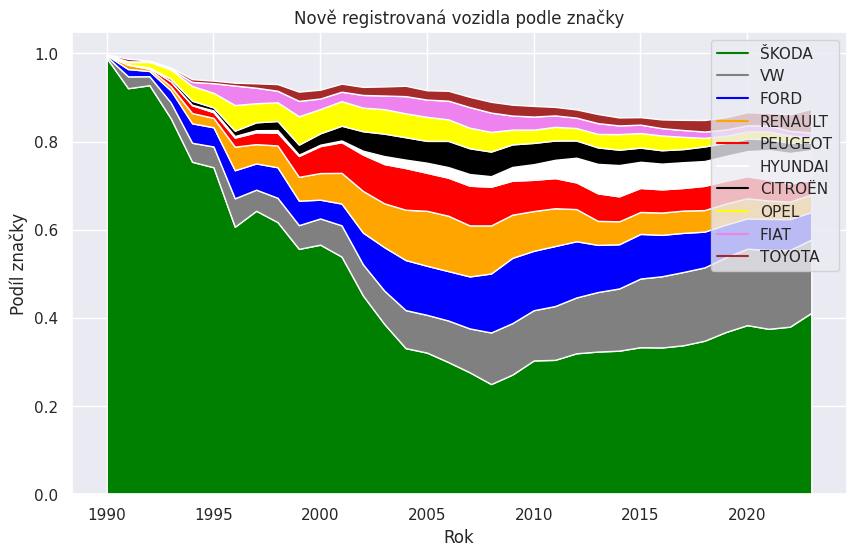

In [35]:
# Standardize to sum of counts in each year = 1.
for year in years:
    total = make_groups_df[make_groups_df['FirstRegistrationCZ'] == year]['Count'].sum()
    for make in top_make:
        make_groups_df.loc[(make_groups_df['FirstRegistrationCZ'] == year) & (make_groups_df['Make'] == make), 'Count'] = make_groups_df[(make_groups_df['FirstRegistrationCZ'] == year) & (make_groups_df['Make'] == make)]['Count'] / total

group_values = [make_groups_df[(make_groups_df['Make'] == make) & (make_groups_df['FirstRegistrationCZ'] >= 1990)]['Count'] for make in top_make]

for i, value in enumerate(top_make):
    plt.plot([], [], label=value, color=color_map[i])

plt.stackplot(list(range(1990, 2024)), group_values, colors=color_map)
plt.title('Nově registrovaná vozidla podle značky')
plt.xlabel('Rok')
plt.ylabel('Podíl značky')
plt.legend()
plt.show()

## Functional processing
Batch processing function to be used for neighbor notebooks (colors and drive types) too.

In [44]:
def process(df_register: pd.DataFrame, column: str) -> pd.DataFrame:
    '''Takes a vehicle register with a given categorical "column", returns the value counts per year both in absolute and numbers and relative to other values in the same year. The vehicle register df should be raw with "FirstRegistrationCZ" being a string timestamp. The df will not be modified, a local copy will be made.'''

    # Prepare the source df
    df = df_register.copy()
    df['FirstRegistrationCZ'] = \
            df['FirstRegistrationCZ'].apply(lambda x: int(x.split('-')[0]))
    df = df[['FirstRegistrationCZ', column]]
    df = df.dropna(subset=[column])

    # Get the time range
    years_max = df['FirstRegistrationCZ'].max()
    years = list(range(1900, int(years_max) + 1))

    # Calculate the groups
    cats = df[column].cat.categories
    groups = df.groupby([column], observed=True)['FirstRegistrationCZ'].value_counts()
    groups_df = pd.DataFrame({'Count': groups}, index=groups.index)

    # Fill missing zeroes
    for year in years:
        for cat in cats:
            if (cat, year) not in groups_df.index:
                groups_df.loc[(cat, year), 'Count'] = 0
    groups_df = groups_df.reset_index()
    groups_df = groups_df.sort_values('FirstRegistrationCZ')

    # Add standardized values
    for year in years:
        total = groups_df[groups_df['FirstRegistrationCZ'] == year]['Count'].sum()
        for cat in cats:
            groups_df.loc[(groups_df['FirstRegistrationCZ'] == year)
                               & (groups_df[column] == cat), 'CountRel'] = \
                    groups_df[(groups_df['FirstRegistrationCZ'] == year)
                                   & (groups_df[column] == cat)]['Count'] / total

    return groups_df


### Test

['OCTAVIA', 'FABIA', 'FELICIA', 'GOLF', 'MEGANE', 'PASSAT', '120', 'FOCUS', 'SUPERB', 'MONDEO', 'FELICIA COMBI', '135', 'ASTRA', 'FABIA COMBI', 'RAPID']


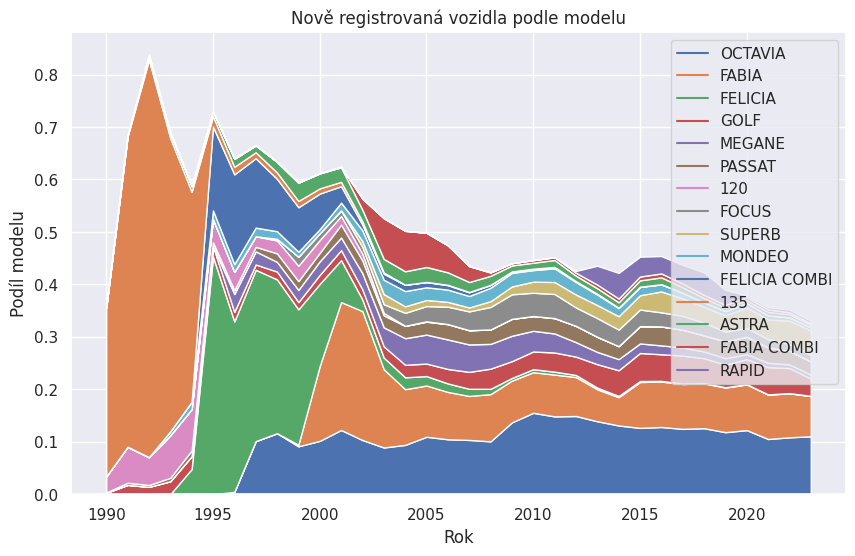

In [59]:
df_register = pd.read_csv(
    f'{register_data_path}nosync/registr_silnicnich_vozidel_2023-02-24.analysis-cleaned-2023-06-13.csv',
    usecols=register_cols,
    dtype=register_dtypes,
    true_values=['True'],
    false_values=['False'],
    encoding_errors='ignore')

top_model = list(df_register['Model'].value_counts().head(15).index)
print(top_model)

groups_df = process(df_register, 'Model')
group_values = [groups_df[(groups_df['Model'] == model) & (groups_df['FirstRegistrationCZ'] >= 1990)]['CountRel'] for model in top_model]

for i, value in enumerate(top_model):
    plt.plot([], [], label=value, color=sns.color_palette()[i % 10])

plt.stackplot(list(range(1990, 2024)), group_values, colors=sns.color_palette())
plt.title('Nově registrovaná vozidla podle modelu')
plt.xlabel('Rok')
plt.ylabel('Podíl modelu')
plt.legend()
plt.show()